<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

In [ ]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install opendartreader
!pip install --upgrade opendartreader

In [8]:
# 필요 라이브러리
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr

# 재무재표 로딩
import OpenDartReader

import datetime

## 재무 지표 및 주식 데이터 로드

In [3]:
def pro_equ(code, start, end):
    # OpenDartReader 사용
    api_key = '9b9157d4313a84f3141d73f879c5d239d49bb0ce'
    dart = OpenDartReader(api_key)
    arr = [] # 재무 정보
    index = [] # 계산지표
    
    # 주식정보
    if type(code) != str:
        code = str(code).zfill(6)       
    
    if type(start) != str:
        start = str(start)
    
    if type(end) != str:
        end = str(end)
        
    stock = fdr.DataReader(code, start = str(int(start)+1), end = end)  # 2021 지표 <- 2020,2019 데이터로 만듬
    stock = stock.reset_index()
    stock['PER'] = 0.1
    stock['PBR'] = 0.1
    stock['ROE'] = 0.1
    stock['ROA'] = 0.1
    
    #         ------------------------
    
    small = dart.report('005930', '소액주주', int(datetime.datetime.now().strftime("%Y"))-1, reprt_code=11014)
    stock_tot_co = int(small['stock_tot_co'].str.replace(',', '')) # 총 발행 주식 수
    
    for i in range(int(start[:4]), int(end[:4])):
        # https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019016 --> 입력변수 명 참고
        # corp: 종목코드, bsns_year: 사업연도, reprt_code: 보고서코드
        # (1분기보고서 : 11013, 반기보고서 : 11012, 3분기보고서 : 11014, 사업보고서 : 11011)
        fs_before = dart.finstate_all(corp = code, bsns_year= str(i-1), fs_div='CFS', reprt_code=11011) 
        fs_present = dart.finstate_all(corp = code, bsns_year= i, fs_div='CFS', reprt_code=11014)

        # 자본, 부채는 당기 금액('thstrm_amount') 값을 통해서 구함
#         equity = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_id'].isin(['ifrs-full_Equity']), 'thstrm_amount'].replace(",", "")) # 당기자본(자본총계)
        equity = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_nm'].isin(['자본총계']), 'thstrm_amount'])
    
#         liability = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_id'].isin(['ifrs-full_Liabilities']), 'thstrm_amount'].replace(",", "")) # 당기부채(부채총계)
        liability = int(fs_present.loc[fs_present['sj_div'].isin(['BS']) & fs_present['account_nm'].isin(['부채총계']), 'thstrm_amount'].replace(",", ""))
        # 자산 총계
        assets = equity + liability
        
        # <예시>
        # 2019 4분기 ~ 2020 3분기까지의 당기순이익의 합을 구하려면 2019년 4분기 당기순이익과 2020년 1분기 ~ 3분기 당기순이익의 합을 알아여함
        # 2020년 1분기 ~ 3분기 당기순이익의 합은 2020년 3분기 손익계산서에서 'thstrm_add_amount' 값을 가져오면 되고
        # 2019년 4분기 당기순이익은 2019년 전체 당기순이익에서 2019년 1분기 ~ 3분기 당기순이익의 합을 빼서 구할 수 있음
        
        # frmtrm_add_amount --> 전기 금액, thstrm_amount ---> 당기 금액, thstrm_add_amount --> 당기 누적금액
#         profit_before_3Q = int(fs_present.loc[fs_present['sj_div'].isin(['IS']) & fs_present['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'frmtrm_add_amount'].replace(",", "")) # 당기순이익
        profit_before_3Q = int(fs_present.loc[fs_present['sj_div'].isin(['IS']) & fs_present['account_nm'].isin(['지배기업의 소유주에게 귀속되는 당기순이익(손실)']), 'frmtrm_add_amount'].replace(",", ""))
        
#         profit_before = int(fs_before.loc[fs_before['sj_div'].isin(['IS']) & fs_before['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'thstrm_amount'].replace(",", "")) # 당기순이익
        profit_before = int(fs_before.loc[fs_before['sj_div'].isin(['IS']) & fs_before['account_nm'].isin(['지배기업의 소유주에게 귀속되는 당기순이익(손실)']), 'thstrm_amount'].replace(",", ""))
        
#         profit_present = int(fs_present.loc[fs_present['sj_div'].isin(['IS']) & fs_present['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'thstrm_add_amount'].replace(",", "")) # 당기순이익
        profit_present = int(fs_present.loc[fs_present['sj_div'].isin(['IS']) & fs_present['account_nm'].isin(['지배기업의 소유주에게 귀속되는 당기순이익(손실)']), 'thstrm_add_amount'].replace(",", "")) # 당기순이익
        
        profit = (profit_before-profit_before_3Q) + profit_present
        
        a = (equity, liability, assets, profit, stock_tot_co) 
        # 자본총계(당기자본), 부채총계(당기부채), 자산총계, 당기 순이익, 총 발행 주식수
        arr.append(a)
        
#         - PER(주가 수익률) : 주가를 1주당 순이익(EPS)로 나눈 값
#         - PBR(주가 순자산 비율) : 주가를 1주당 순자산가치로 나눈 값
#         - ROE(자기자본이익률) : 당기순이익을 순자산(자기자본)으로 나눈 값
#         - ROA(총자산수익률) : 당기순이익을 자산총액으로 나눈 값
        
#         print(stock[stock['Date'].dt.year == i]['Close'])
            
        
        ROA = profit/assets
        stock.loc[stock['Date'].dt.year == i+1,'ROA'] = ROA
        
        EPS = profit/stock_tot_co
        PER = stock.loc[stock['Date'].dt.year == i+1,'Close']/EPS
        
#         PER = stock[stock['Date'].dt.year == i+1]['Close']/EPS
        
        BPS = equity/stock_tot_co
        PBR = stock.loc[stock['Date'].dt.year == i+1, 'Close']/BPS
#         PBR = stock[stock['Date'].dt.year == i+1]['Close']/BPS
        
        for i in PER.index:
            stock['PER'][i] = PER[i]
            stock['PBR'][i] = PBR[i]
        
        b = (EPS,BPS)
        # EPS: 순이익/총발행주식수 --> 개당 이익률?
        # BPS: 순자산/총발행 주식수 --> 개당 자산?
        
        index.append(b)
        
    stock['ROE'] = stock['PBR']/stock['PER']
    
    return arr,index, stock

In [9]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
arr, indexs, df = pro_equ(5930,2017,end_date)

In [10]:
arr

[(210691251000000,
  85887328000000,
  296578579000000,
  36245426000000,
  5969782550),
 (242103160000000,
  95092626000000,
  337195786000000,
  47577132000000,
  5969782550),
 (263442244000000,
  89943741000000,
  353385985000000,
  24607128000000,
  5969782550),
 (276136188000000,
  99652554000000,
  375788742000000,
  24873372000000,
  5969782550)]

In [11]:
indexs

[(6071.481782866614, 35292.952337099785),
 (7969.659129376496, 40554.77029058621),
 (4121.947121842822, 44129.28641764347),
 (4166.54573121763, 46255.65264517047)]

In [12]:
df

,Date,Open,High,Low,Close,Volume,Change,PER,PBR,ROE,ROA
0,2018-01-02,51380,51400,50780,51020,169485,0.001177,8.403220,1.445614,0.172031,0.122212
1,2018-01-03,52540,52560,51420,51620,200270,0.011760,8.502043,1.462615,0.172031,0.122212
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461,8.413103,1.447314,0.172031,0.122212
3,2018-01-05,51300,52120,51200,52120,189623,0.020360,8.584395,1.476782,0.172031,0.122212
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919,8.567925,1.473949,0.172031,0.122212
...,...,...,...,...,...,...,...,...,...,...,...
907,2021-09-06,76800,77600,76600,77300,12861180,0.009138,18.552538,1.671147,0.090076,0.066190
908,2021-09-07,77100,77100,75900,76100,13239401,-0.015524,18.264530,1.645204,0.090076,0.066190
909,2021-09-08,76000,76400,75600,76300,11798147,0.002628,18.312532,1.649528,0.090076,0.066190
910,2021-09-09,76400,76600,75000,75300,17600770,-0.013106,18.072525,1.627909,0.090076,0.066190


## 데이터 전처리

In [14]:
df1 = df.drop(columns=['Date'],axis = 1)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
scale_cols = list(df1.columns)
# 스케일 후 columns
scaled = scaler.fit_transform(df1[scale_cols])
scaled

array([[5.68992248e-01, 5.30991736e-01, 5.67374302e-01, ...,
        5.00219916e-01, 7.69963641e-01, 7.47891935e-01],
       [5.81838317e-01, 5.42975207e-01, 5.74525140e-01, ...,
        5.16505779e-01, 7.69963641e-01, 7.47891935e-01],
       [5.77187154e-01, 5.39049587e-01, 5.65810056e-01, ...,
        5.01848502e-01, 7.69963641e-01, 7.47891935e-01],
       ...,
       [8.41638981e-01, 7.89256198e-01, 8.44692737e-01, ...,
        6.95561175e-01, 1.11022302e-16, 0.00000000e+00],
       [8.46068660e-01, 7.91322314e-01, 8.37988827e-01, ...,
        6.74851050e-01, 1.11022302e-16, 0.00000000e+00],
       [8.33887043e-01, 7.80991736e-01, 8.35754190e-01, ...,
        6.74851050e-01, 1.11022302e-16, 0.00000000e+00]])

In [19]:
df1 = pd.DataFrame(scaled, columns=scale_cols)
df1

,Open,High,Low,Close,Volume,Change,PER,PBR,ROE,ROA
0,0.568992,0.530992,0.567374,0.253408,0.001877,0.385888,0.216092,0.500220,7.699636e-01,0.747892
1,0.581838,0.542975,0.574525,0.264613,0.002218,0.448663,0.221857,0.516506,7.699636e-01,0.747892
2,0.577187,0.539050,0.565810,0.254528,0.002590,0.316851,0.216668,0.501849,7.699636e-01,0.747892
3,0.568106,0.538430,0.572067,0.273950,0.002100,0.499677,0.226661,0.530077,7.699636e-01,0.747892
4,0.580288,0.542562,0.575419,0.272082,0.001857,0.367523,0.225700,0.527363,7.699636e-01,0.747892
...,...,...,...,...,...,...,...,...,...,...
907,0.850498,0.801653,0.855866,0.744164,0.142418,0.433111,0.808180,0.716271,1.110223e-16,0.000000
908,0.853821,0.796488,0.848045,0.721755,0.146606,0.286819,0.791378,0.691419,1.110223e-16,0.000000
909,0.841639,0.789256,0.844693,0.725490,0.130646,0.394494,0.794178,0.695561,1.110223e-16,0.000000
910,0.846069,0.791322,0.837989,0.706816,0.194901,0.301161,0.780177,0.674851,1.110223e-16,0.000000


In [20]:
x_train, x_test, y_train, y_test = train_test_split(df1.drop('Close', 1), df1['Close'], test_size=0.2, random_state=0, shuffle=False)

x_train.shape, y_train.shape

((729, 9), (729,))

In [21]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

In [22]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [23]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, feature갯수): (32, 1)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential()

model.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences= True))
model.add(LSTM(64,
               input_shape = (None, 1),
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [34]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [35]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
23/23 [==============================] - 5s 58ms/step - loss: 0.0046 - mse: 0.0092 - val_loss: 0.0179 - val_mse: 0.0358

Epoch 00001: val_loss improved from inf to 0.01790, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
23/23 [==============================] - 1s 18ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 6.8662e-04 - val_mse: 0.0014

Epoch 00002: val_loss improved from 0.01790 to 0.00069, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
23/23 [==============================] - 1s 17ms/step - loss: 7.4851e-04 - mse: 0.0015 - val_loss: 0.0032 - val_mse: 0.0063

Epoch 00003: val_loss did not improve from 0.00069
Epoch 4/50
23/23 [==============================] - 1s 18ms/step - loss: 7.0429e-04 - mse: 0.0014 - val_loss: 0.0030 - val_mse: 0.0059

Epoch 00004: val_loss did not improve from 0.00069
Epoch 5/50
23/23 [==============================] - 1s 17ms/step - loss: 6.6645e-04 - mse: 0.0013 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00005: val_loss did not improve 

In [36]:
import numpy as np


In [37]:
model.load_weights(filename)
pred = model.predict(test_data)

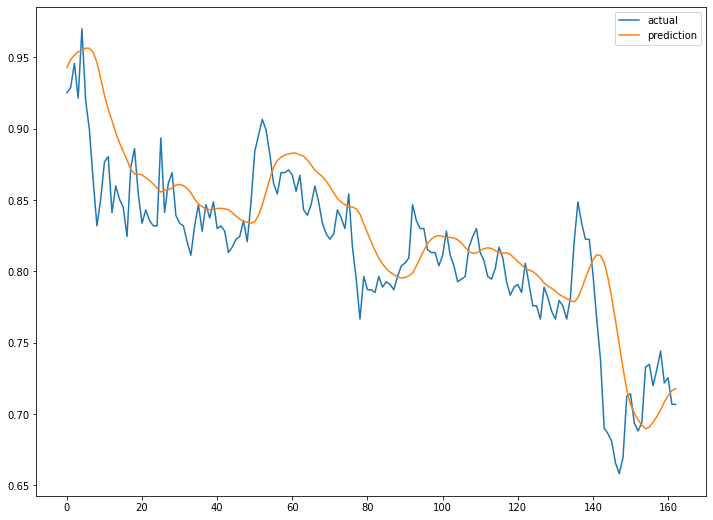

In [38]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()